# Evolution of the Upper Vegetation Limit in the Lötschen Valley (Geospatial Analysis notebook)

*SGG.00425: Data and methods for environmental analysis*

Author: Bart Kevin, Bosson Zoélie, Rey Thomas. Assisted by: Prof. POHL Eric & Prof. MACHGUTH Horst  

Date: November 6, 7, 13 and 14, 2025

## Importing necessary libraries

In [2]:
import pandas as pd                 # Pour la manipulation des données
import numpy as np                  # Pour les calculs numériques
from pathlib import Path            # Pour la gestion des chemins de fichiers
import matplotlib.pyplot as plt     # Pour la visualisation
from matplotlib import cm           # Pour les colormaps
import pickle                       # Pour la sérialisation des objets Python

## Get the altitude for our region

In our `dataset_final_1984_2025.nc` file, we have the x, y coordinates of our study area but the altitude is missing. So we'll use [SwissALTI3D](https://www.swisstopo.admin.ch/fr/modele-altimetrique-swissalti3d) to get the altitude data. First we download the data from the SwissALTI3D website all the links are listed [here](../data/external/links.txt). Those files are `.xyz` which contains the x, y coordinates and the altitude. As this is quite a large amount of data, we don't include it in the repository, but here is what we did:

- We exported the x, y coordinates from our `dataset_final_1984_2025.nc` file and saved them in a `.csv` file.
- For each coordinate, we searched for the corresponding altitude in the `.xyz` files downloaded from SwissALTI3D.
- We saved the altitude data in the [`points_with_z.csv`](../data/processed/points_with_z.csv) file.

In [3]:
file = r"..\data\processed\points_with_z.csv"
data = pd.read_csv(file)

# Extract coordinates and altitude
data_X=data['X']
data_Y=data['Y']
altitudes = data['Z'].to_numpy()

### Some plots to visualize our altitude data

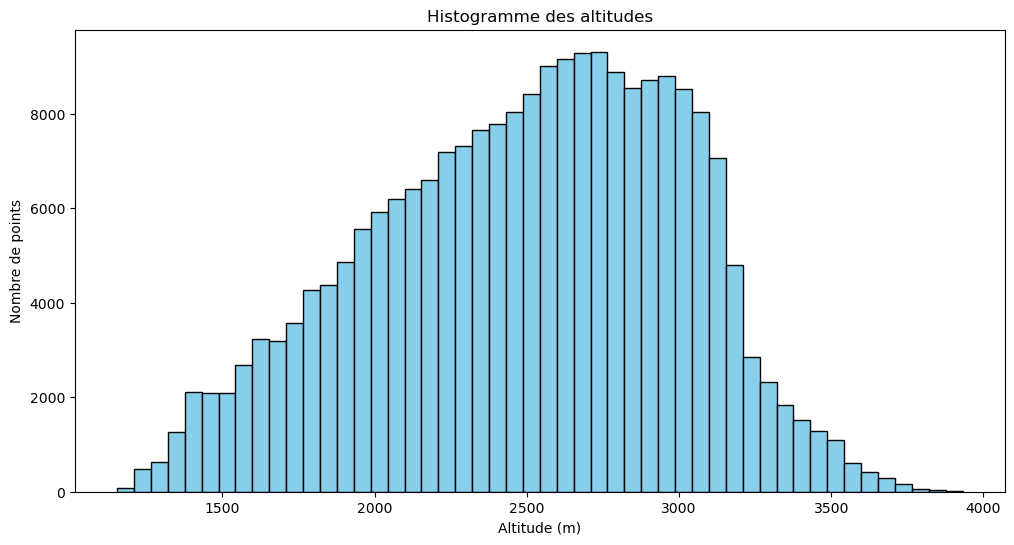

In [4]:
plt.figure(figsize=(12,6))
plt.hist(altitudes, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogramme des altitudes")
plt.xlabel("Altitude (m)")
plt.ylabel("Nombre de points")
plt.show()

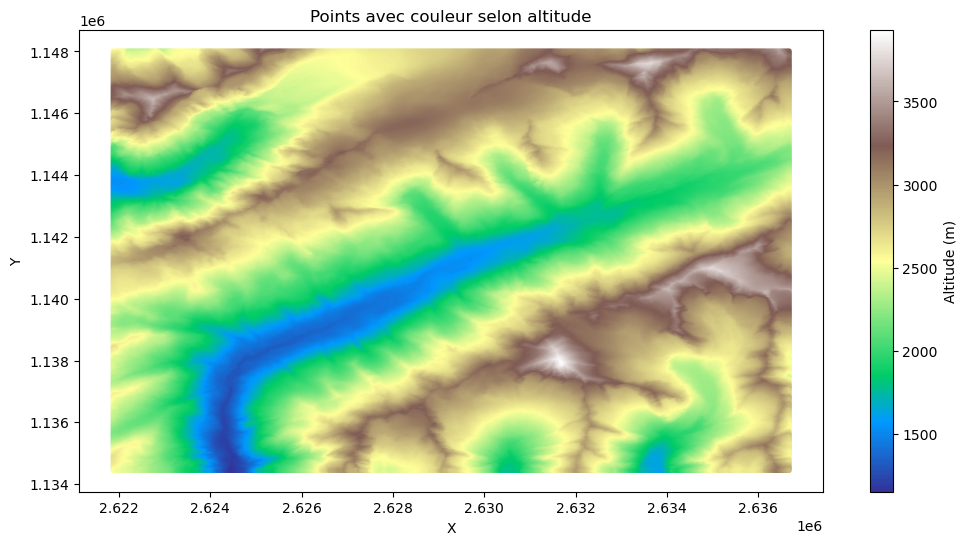

In [5]:
plt.figure(figsize=(12,6))
plt.scatter(data_X, data_Y, c=data['Z'], cmap='terrain', s=5)
plt.colorbar(label='Altitude (m)')
plt.title("Points avec couleur selon altitude")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Selection of the north and south faces of the study area

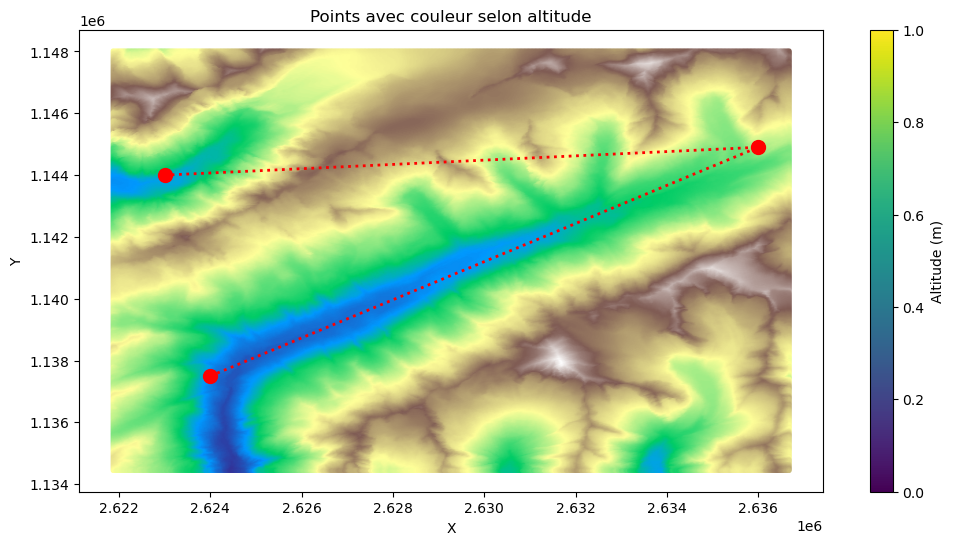

In [6]:
points_X=np.array([2.624,2.636, 2.623])*1e6
points_Y=np.array([1.1375,1.1449,1.144])*1e6

plt.figure(figsize=(12,6))
plt.scatter(data_X, data_Y, c=data['Z'], cmap='terrain', s=5)
plt.scatter(points_X, points_Y, color="red", s=100, zorder=5)
plt.plot(points_X, points_Y, color="red", linestyle=":", linewidth=2)
plt.colorbar(label='Altitude (m)')
plt.title("Points avec couleur selon altitude")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Droite du milieu : y = 0.62 x + (-480633.33)
Droite du haut (gauche) : y = 0.62 x + (-475533.33)
Droite du haut (droite): y = 0.62 x + (-483633.33)


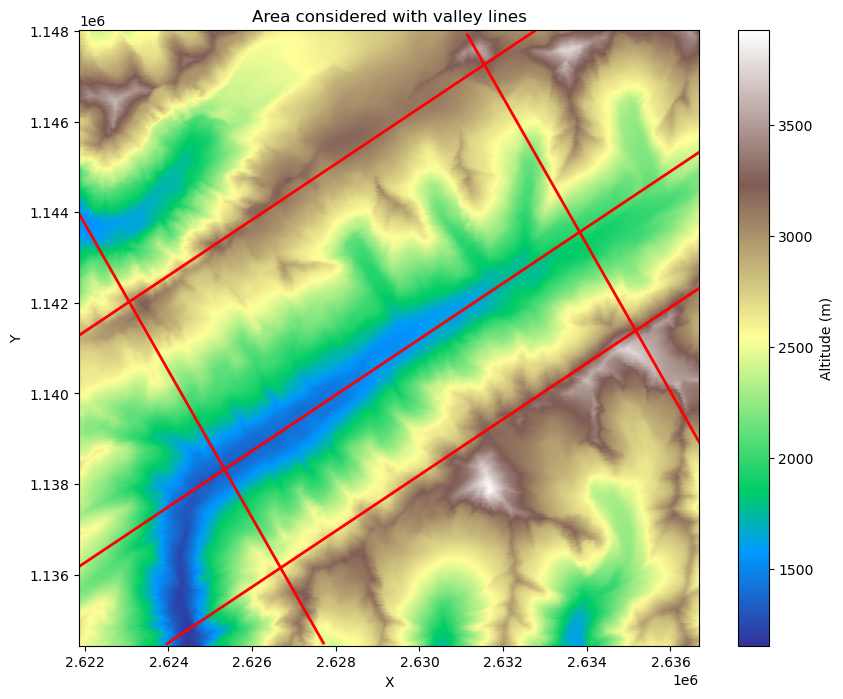

In [6]:
# -------------------------
# Calcul des droites
# -------------------------
# Pente de la vallée
a = (points_Y[1] - points_Y[0]) / (points_X[1] - points_X[0])

# Ordonnée à l'origine de la droite du milieu
b_down = points_Y[0] - a * points_X[0]

# Droites "haut-gauche" et "haut-droite"
b_up_left = b_down + 0.0051*1e6
b_up_right = b_down - 0.003*1e6

print(f"Droite du milieu : y = {a:.2f} x + ({b_down:.2f})")
print(f"Droite du haut (gauche) : y = {a:.2f} x + ({b_up_left:.2f})")
print(f"Droite du haut (droite): y = {a:.2f} x + ({b_up_right:.2f})")

# -------------------------
# Limites de la figure
# -------------------------
x_min, x_max = data_X.min(), data_X.max()
y_min, y_max = data_Y.min(), data_Y.max()

x_range = np.linspace(x_min, x_max, 100)

def plot_limited_line(x_vals, slope, intercept, color='red', linestyle=':', linewidth=2):
    y_vals = slope * x_vals + intercept
    # limiter y_vals à y_min et y_max
    mask = (y_vals >= y_min) & (y_vals <= y_max)
    plt.plot(x_vals[mask], y_vals[mask], color=color, linestyle=linestyle, linewidth=linewidth)

# -------------------------
# Préparer la perpendiculaire
# -------------------------
a_perp = -1/a
b_perp_left=points_Y[0]-a_perp*points_X[0] + 0.003*1e6
b_perp_right=points_Y[0]-a_perp*points_X[0] + 0.022*1e6

# -------------------------
# Tracé
# -------------------------
plt.figure(figsize=(10,8))
plt.scatter(data_X, data_Y, c=data['Z'], cmap='terrain', s=5)

# Droites le long de la vallée
plot_limited_line(x_range, a, b_down, color='red', linestyle="-")
plot_limited_line(x_range, a, b_up_left, color='red', linestyle="-")
plot_limited_line(x_range, a, b_up_right, color='red', linestyle="-")
plot_limited_line(x_range, -1/a, b_perp_left, color='red', linestyle="-")
plot_limited_line(x_range, -1/a, b_perp_right, color='red', linestyle="-")

# Axes et colorbar
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.colorbar(label='Altitude (m)')
plt.title("Area considered with valley lines")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Now that we have the north and south zone, we create masks to isolate these areas for further analysis.

In [7]:
# Droite vallée
y_mid = a * data_X + b_down
y_top = a * data_X + b_up_left
y_bottom = a * data_X + b_up_right

# Droite perpendiculaire
y_perp_left = a_perp * data_X + b_perp_left
y_perp_right = a_perp * data_X + b_perp_right

#masque nord
mask_north = (data_Y >= y_mid) & (data_Y <= y_top) & (data_Y >= y_perp_left) & (data_Y <= y_perp_right)
points_north = data[mask_north]

#masque sud
mask_south = (data_Y >= y_bottom) & (data_Y <= y_mid) & (data_Y >= y_perp_left) & (data_Y <= y_perp_right)
points_south = data[mask_south]

c:\Users\kevin\anaconda3\envs\pystac_env_analysis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


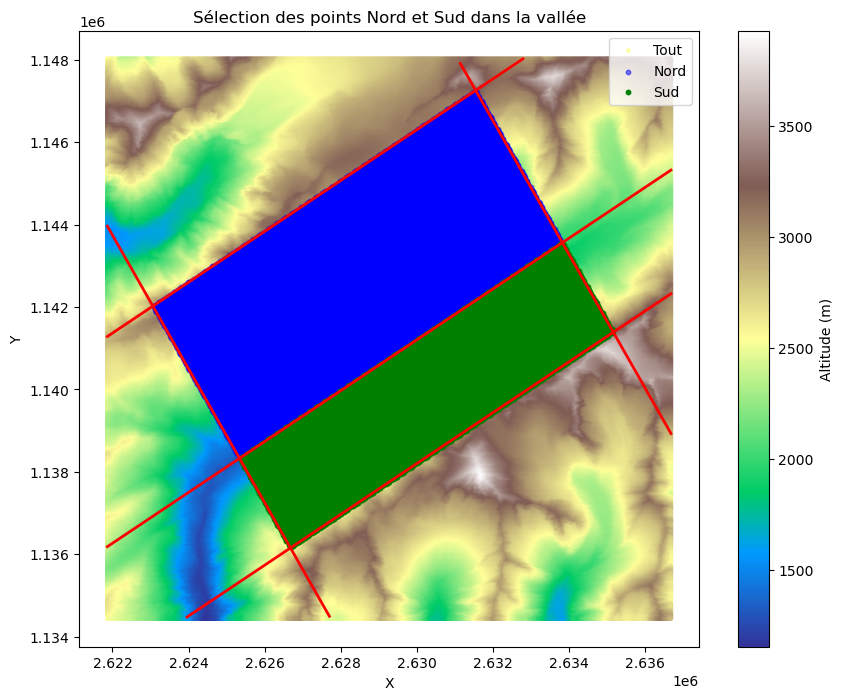

In [8]:
plt.figure(figsize=(10,8))

# Affichage de tous les points en léger gris
plt.scatter(data_X, data_Y, c=data['Z'], cmap='terrain', s=5, label='Tout')
plt.colorbar(label='Altitude (m)')


# Points Nord et Sud
plt.scatter(points_north['X'], points_north['Y'], color='blue', s=10, label='Nord', alpha=0.5)
plt.scatter(points_south['X'], points_south['Y'], color='green', s=10, label='Sud')

# Droites le long de la vallée et perpendiculaires
plot_limited_line(x_range, a, b_down, color='red', linestyle='-')
plot_limited_line(x_range, a, b_up_left, color='red', linestyle='-')
plot_limited_line(x_range, a, b_up_right, color='red', linestyle='-')
plot_limited_line(x_range, a_perp, b_perp_left, color='red', linestyle='-')
plot_limited_line(x_range, a_perp, b_perp_right, color='red', linestyle='-')

# Axes et colorbar
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sélection des points Nord et Sud dans la vallée")
plt.legend()
plt.show()

## Save the north and south mask to CSV files

Here we just have to be careful to save the correct data for each zone. Actually we have the `points_north` corresponding to the south facing face and `points_south` corresponding to the north facing face.

In [9]:
# # Définir les chemins des fichiers
# output_north = r"..\data\processed\points_north_face.csv"
# output_south = r"..\data\processed\points_south_face.csv"

# # Exporter les données attention a swap les points_north -> south face et points_south -> north face
# points_north.to_csv(output_south, index=False)
# points_south.to_csv(output_north, index=False)

# print(f"Points Nord enregistrés dans : {output_north}")
# print(f"Points Sud enregistrés dans : {output_south}")

## Visualization of the north and south mask by altitude slice

In [10]:
def split_by_altitude(data, interval=200, column='Z'):
    """
    Sépare un DataFrame en sous-ensembles selon des intervalles d'altitude.

    Args:
        data (pd.DataFrame): DataFrame contenant une colonne d'altitude.
        interval (int): Longueur de l'intervalle en mètres.
        column (str): Nom de la colonne contenant l'altitude.

    Returns:
        dict: clés = (min, max) de l'intervalle, valeurs = DataFrame correspondant
    """
    z_min = np.floor(data[column].min() / interval) * interval
    z_max = data[column].max()

    intervals = np.arange(z_min, z_max + interval, interval)
    
    result = {}
    for i in range(len(intervals)-1):
        lower = intervals[i]
        upper = intervals[i+1]
        mask = (data[column] >= lower) & (data[column] < upper)
        result[(lower, upper)] = data[mask]
    
    return result

In [11]:
# Charger le CSV
north_face = pd.read_csv(r"..\data\processed\points_north_face.csv")
south_face = pd.read_csv(r"..\data\processed\points_south_face.csv")

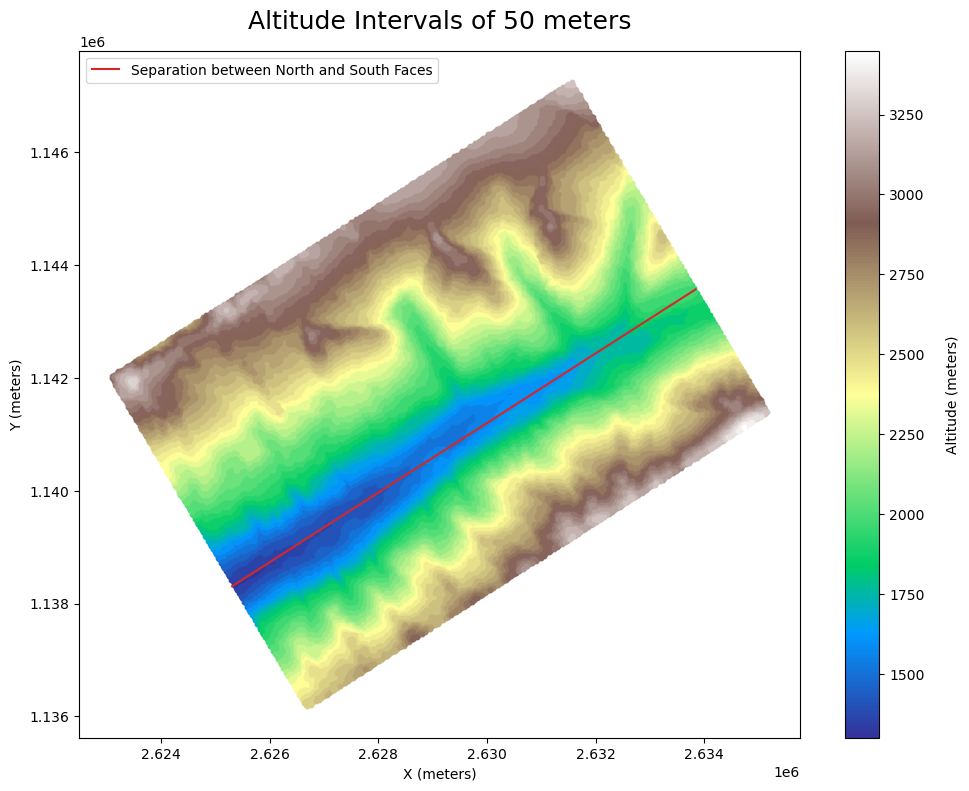

In [22]:
# Définir l'intervalle d'altitude
altitude_interval = 50

# Découper en intervalles de 200 m
altitude_bins_north = split_by_altitude(north_face, interval=altitude_interval)
altitude_bins_south = split_by_altitude(south_face, interval=altitude_interval)

# Récupérer toutes les bornes d'altitude
all_alt_bounds = [key for key in altitude_bins_north.keys()] + [key for key in altitude_bins_south.keys()]
z_min = min(b[0] for b in all_alt_bounds) # Minimum de toutes les bornes inférieures
z_max = max(b[1] for b in all_alt_bounds) # Maximum de toutes les bornes supérieures

# Créer l'objet Colormap et Normalisation
cmap = cm.terrain
norm = plt.Normalize(vmin=z_min, vmax=z_max)

# Créer un ScalarMappable (l'objet fantôme pour la Color Bar)
# Cet objet simule le tracé continu, mais ne sera pas affiché.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Obligatoire, mais ne contient pas de données réelles

# --- Tracé Principal ---
plt.figure(figsize=(10,8))

# Palette unique pour les altitudes (Gardée pour les tracés discrets)
n_bins = max(len(altitude_bins_north), len(altitude_bins_south))
colors = cm.terrain(np.linspace(0, 1, n_bins))

# Tracer la face Nord 
for i, (color, (alt_range, df)) in enumerate(zip(colors, altitude_bins_north.items())):
    # Si c'est la première itération, on ajoute un label pour la légende du marqueur 'o'
    label = "North Face" if i == 0 else None
    
    plt.scatter(df['X'], df['Y'], color=color, s=10) 

# Tracer la face Sud
for i, (color, (alt_range, df)) in enumerate(zip(colors, altitude_bins_south.items())):
    # Si c'est la première itération, on ajoute un label pour la légende du marqueur 'x'
    label = "South Face" if i == 0 else None
    
    plt.scatter(df['X'], df['Y'], color=color, s=10) # Le label est pour le marqueur 'x'

# Tracé de la ligne de séparation
plt.plot(x_range[23:-19], a * x_range[23:-19] + b_down, color='tab:red', linestyle='-', label='Separation between North and South Faces')

# --- Ajout de la Color Bar ---
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Altitude (meters)', labelpad=15)

# --- Finalisation du Plot ---
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title(f"Altitude Intervals of {altitude_interval} meters", fontsize=18, y=1.02)
plt.legend()
plt.tight_layout()
# plt.savefig(rf"..\figures\altitude_intervals_{altitude_interval}m.png", dpi=300, bbox_inches='tight')
plt.show()

## Save different altitude slices to pickle files

Finally we can save the different altitude slices with different intervals as pickle files for further analysis. We'll use those pickle files to compute the vegetation indices for each altitude slice.

In [15]:
# # Définition de l'intervalle (remplacez 5 par votre valeur si elle est différente)
# altitude_interval = 20 

# # 1. Calcul des intervalles
# altitude_bins_north = split_by_altitude(north_face, interval=altitude_interval)
# altitude_bins_south = split_by_altitude(south_face, interval=altitude_interval)

# # 2. Sauvegarde des résultats (Sérialisation)

# # Sauvegarde pour la face Nord
# north_filename = rf"..\data\processed\altitude_bins_north_{altitude_interval}.pkl"
# with open(north_filename, "wb") as f:
#     pickle.dump(altitude_bins_north, f)

# # Sauvegarde pour la face Sud
# south_filename = rf"..\data\processed\altitude_bins_south_{altitude_interval}.pkl"
# with open(south_filename, "wb") as f:
#     pickle.dump(altitude_bins_south, f)

# print(f"Les dictionnaires d'altitude ont été sauvegardés dans : {north_filename} et {south_filename}")

Les dictionnaires d'altitude ont été sauvegardés dans : ..\data\processed\altitude_bins_north_20.pkl et ..\data\processed\altitude_bins_south_20.pkl
